In [16]:
import itertools

import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy
import scipy


%matplotlib inline

In [4]:
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/gh-pages/data/drugbank-slim.tsv'
drugbank_df = pandas.read_table(url)
drugbank_df.head()

url = 'https://raw.githubusercontent.com/dhimmel/drugbank/gh-pages/data/proteins.tsv'
protein_df = pandas.read_table(url)
# remove rows from protein_df whose drugbank_ids are not in the slim dataset
protein_df = protein_df[protein_df.drugbank_id.isin(drugbank_df.drugbank_id)]
protein_df.head()

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids
5,DB00170,target,P00734,2147,Human,unknown,activator,10469489|2484931|2922761|6867080|7657295
6,DB00278,target,P00734,2147,Human,yes,inhibitor,10226408|10353669|10362188|10608016|10608050|1...
7,DB01123,target,P00734,2147,Human,no,other/unknown,1711542|4857231|6722124|7407200|7837275|10592235
23,DB04786,target,P00734,2147,Human,unknown,inhibitor,15203120
24,DB04898,target,P00734,2147,Human,yes,inhibitor,17688383|17319469|17516699|17532684|11752352


In [5]:
#merge the two tables
df_protein_merge = pandas.merge(drugbank_df, protein_df)
df_protein_merge

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids
0,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,target,P30968,2798,Human,yes,agonist,20053189
1,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,target,P22888,3973,Human,yes,agonist,17139284|17016423|20053189
2,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,enzyme,P35354,5743,Human,unknown,inducer,15644490
3,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,target,P30518,554,Human,yes,agonist,18761325|16333859|11752352
4,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,target,P37288,552,Human,yes,NaN,10731046|10594321|8957254|15613460
5,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,target,P47901,553,Human,yes,NaN,15613460|14971638|18655906
6,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,enzyme,P23219,5742,Human,unknown,inducer,15644490
7,DB00050,Cetrorelix,small molecule,approved|investigational,H01CC02,Hormone Antagonists|Fertility Agents,InChIKey=SBNPWPIBESPSIF-MHWMIDJBSA-N,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,target,P30968,2798,Human,yes,antagonist,11854630|12606421|14561652|14605254|16809153|1...
8,DB00050,Cetrorelix,small molecule,approved|investigational,H01CC02,Hormone Antagonists|Fertility Agents,InChIKey=SBNPWPIBESPSIF-MHWMIDJBSA-N,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,target,P22888,3973,Human,unknown,NaN,17139284|17016423|11943741
9,DB00091,Cyclosporine,small molecule,approved|investigational,L04AD01|S01XA18,Antirheumatic Agents|Dermatologic Agents|Immun...,InChIKey=PMATZTZNYRCHOR-IMVLJIQENA-N,InChI=1/C62H111N11O12/c1-25-27-28-40(15)52(75)...,transporter,P08183,5243,Human,unknown,substrate|inhibitor|inducer,12387747|10820137|10891114|11405287|11716514|1...


In [6]:
#definition of a jaccard function with two inputss set_0 and set_1
def jaccard(set_0, set_1):
    set_0 = set(set_0)
    set_1 = set(set_1)
    numbers_in_common = len(set_0 & set_1)
    total_number = len(set_0 | set_1)
    if total_number == 0:
        return 0
    jaccard = float(numbers_in_common) / total_number
    return jaccard

In [7]:
protein_dict = dict()

for (drugbank_id, category), df in protein_df.groupby(['drugbank_id', 'category']):
    genes = set(df.entrez_gene_id)
    category_dict = protein_dict.setdefault(drugbank_id, dict())
    category_dict[category] = genes

In [8]:
categories = set(df_protein_merge['category'])


In [9]:
rows= list()

pairs = itertools.combinations(protein_dict, 2)
for compound_0, compound_1 in pairs:
    for category in categories:
        genes_0 = protein_dict[compound_0].get(category, set())
        genes_1 = protein_dict[compound_1].get(category, set())
        jc = jaccard(genes_0, genes_1)
        row = compound_0, compound_1, category, jc
        rows.append(row)

In [10]:
jaccard_df = pandas.DataFrame(rows, columns=['compound_0', 'compound_1', 'category', 'jaccard'])
spread_df = jaccard_df.set_index(['compound_0', 'compound_1', 'category']).unstack().jaccard#.reset_index()

In [11]:
df = spread_df[['enzyme', 'target', 'carrier', 'transporter']]
df.head()

category               enzyme  target  carrier  transporter
compound_0 compound_1                                      
DB00014    DB00035          0       0        0            0
           DB00050          0       1        0            0
           DB00104          0       0        0            0
           DB00115          0       0        0            0
           DB00116          0       0        0            0

996166


C:\Users\DanielH\Anaconda3\envs\python2\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


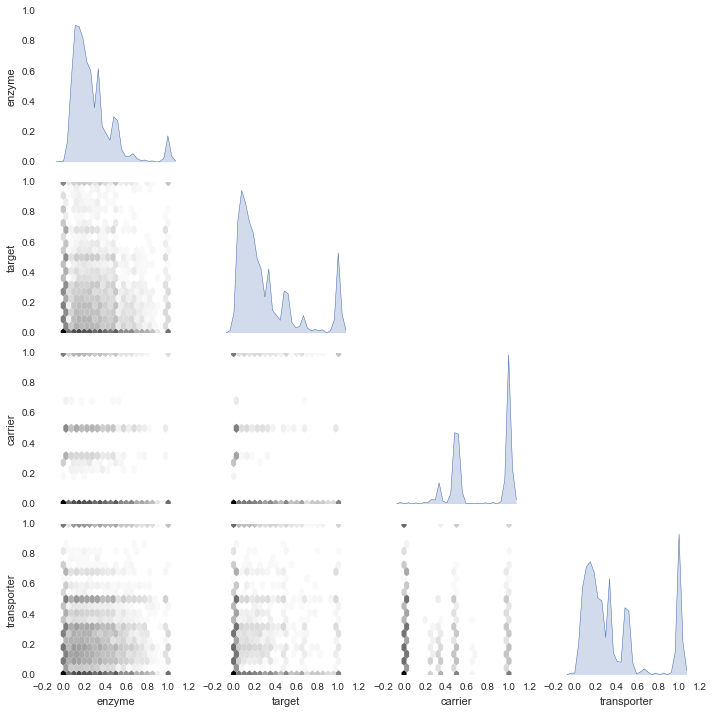

In [12]:
df = spread_df[['enzyme', 'target', 'carrier', 'transporter']]
#df = df[(df > 0).any(axis=1)]
print(len(df))
#df = df.iloc[:500000,:]
g = seaborn.PairGrid(df, diag_sharey=False)
g.map_lower(plt.hexbin, gridsize=20, bins= "log", edgecolor='none')
#bins="log":  log(i+1) is used to determine the hexagon color
#g.map_upper(plt.scatter, lw=.00001, alpha=.05)
g.map_diag(seaborn.kdeplot, lw=5,gridsize=20, shade=True, bw=.0237, linewidth=0.5)
#bw:bandwidth

In [13]:
#make all values >0 in table as 1
spread_df[spread_df != 0] = 1

In [14]:
def contingency_table(df):
    a = df.iloc[:,0]>0
    b = df.iloc[:,1]>0
    df = df.groupby([a,b]).count()
    return df

In [17]:
contingency_dict= {}

for pair in itertools.combinations(spread_df.columns, 2):
    pair_df = spread_df[list(pair)]
    cont_table = contingency_table(pair_df).icol(1).unstack()
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table)
    contingency_dict[pair]=cont_table

In [19]:
freq_dict={}

true_list=[]
false_list=[]
key_list=[]
for key in contingency_dict:
    a = contingency_dict[key]
    true = float(a.iloc[1][1])/(a.iloc[0][1]+a.iloc[1][1])
    false = float(a.iloc[1][0])/(a.iloc[1][0]+a.iloc[0][0])
    true_list.append(true)
    false_list.append(false)
    
    
    freq_dict["True"]=true_list
    freq_dict["False"]=false_list
    str = "-"
    key_list.append(str.join(key))
    freq_df = pandas.DataFrame(data=freq_dict)
    freq_df['Type'] = key_list
    
    freq_df=pandas.melt(freq_df, "Type")

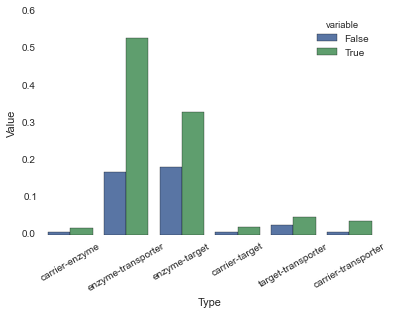

In [22]:
x=freq_df['Type']
freq_barplot=seaborn.barplot(x, y=freq_df['value'], hue=freq_df['variable'])
freq_barplot.set_xticklabels(x, rotation=30) #rotate text
ax= freq_barplot.set_ylabel("Value")